In [11]:
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import pickle

In [12]:
dataset_path = 'CNN letter Dataset'
IMG_SIZE = 20  # 20x20 pixels
NUMBERS = set("0123456789")
LETTERS = set("BCDFGHJKLMNPRSTVWXYZ")


def load_dataset_by_type(dataset_path, char_set):
    data = []
    labels = []

    # Iterate over each digit/letter folder (e.g., 0, A, B, etc.)
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)

        # Ensure the folder name is a valid digit/letter in the provided set
        if label in char_set:
            # Iterate over each image file in the digit/letter folder
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)

                # Load the image in grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Resize to a fixed size (20x20)
                img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Flatten the image into a single feature vector
                img_flattened = img_resized.flatten()

                # Append the image data and label
                data.append(img_flattened)
                labels.append(label)  # Use folder name as the label

    # Convert lists to NumPy arrays
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels)

    return data, labels

# Load number and letter datasets separately
train_data_numbers, train_labels_numbers = load_dataset_by_type(dataset_path, NUMBERS)
train_data_letters, train_labels_letters = load_dataset_by_type(dataset_path, LETTERS)

# Encode labels as integers for both numbers and letters
label_encoder_numbers = LabelEncoder()
train_labels_numbers_encoded = label_encoder_numbers.fit_transform(train_labels_numbers)

label_encoder_letters = LabelEncoder()
train_labels_letters_encoded = label_encoder_letters.fit_transform(train_labels_letters)

# Split datasets into training and testing sets
X_train_numbers, X_test_numbers, y_train_numbers, y_test_numbers = train_test_split(
    train_data_numbers, train_labels_numbers_encoded, test_size=0.2, random_state=42
)

X_train_letters, X_test_letters, y_train_letters, y_test_letters = train_test_split(
    train_data_letters, train_labels_letters_encoded, test_size=0.2, random_state=42
)

save_directory = 'OCR_models/KNN/'
with open(os.path.join(save_directory, 'label_encoder_numbers.pkl'), 'wb') as f:
    pickle.dump(label_encoder_numbers, f)

with open(os.path.join(save_directory, 'label_encoder_letters.pkl'), 'wb') as f:
    pickle.dump(label_encoder_letters, f)

print("Label encoders saved successfully!")

# Print some information about the datasets
print(f'Numbers data shape: {train_data_numbers.shape}')
print(f'Number of number samples: {len(train_labels_numbers)}')
print(f'Letter data shape: {train_data_letters.shape}')
print(f'Number of letter samples: {len(train_labels_letters)}')
print(f'Number classes: {label_encoder_numbers.classes_}')
print(f'Letter classes: {label_encoder_letters.classes_}')


Label encoders saved successfully!
Numbers data shape: (10300, 400)
Number of number samples: 10300
Letter data shape: (20150, 400)
Number of letter samples: 20150
Number classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Letter classes: ['B' 'C' 'D' 'F' 'G' 'H' 'J' 'K' 'L' 'M' 'N' 'P' 'R' 'S' 'T' 'V' 'W' 'X'
 'Y' 'Z']


In [19]:


#split data into training and testing sets
n_neighbors_numbers = 30
n_neighbors_letters = 30


#------------------------------
# Train two separate KNN models for numbers and letters
knn_numbers = KNeighborsClassifier(n_neighbors=n_neighbors_numbers)
knn_numbers.fit(X_train_numbers, y_train_numbers)

knn_letters = KNeighborsClassifier(n_neighbors=n_neighbors_letters)
knn_letters.fit(X_train_letters, y_train_letters)

# Save the trained models
knn_numbers_model_path = os.path.join(save_directory, 'knn_numbers_model_' + str(n_neighbors_numbers) + '.pkl')
knn_letters_model_path = os.path.join(save_directory, 'knn_letters_model_' + str(n_neighbors_letters) + '.pkl')
with open(knn_numbers_model_path, 'wb') as f:
    pickle.dump(knn_numbers, f)

with open(knn_letters_model_path, 'wb') as f:
    pickle.dump(knn_letters, f)

print("KNN models for numbers and letters saved successfully!")

#------------------------------

#evaluate the models on the test set
number_accuracy = knn_numbers.score(X_test_numbers, y_test_numbers)
letter_accuracy = knn_letters.score(X_test_letters, y_test_letters)

print(f'Accuracy of numbers model: {number_accuracy * 100:.2f}%')
print(f'Accuracy of letters model: {letter_accuracy * 100:.2f}%')

KNN models for numbers and letters saved successfully!
Accuracy of numbers model: 96.41%
Accuracy of letters model: 97.25%


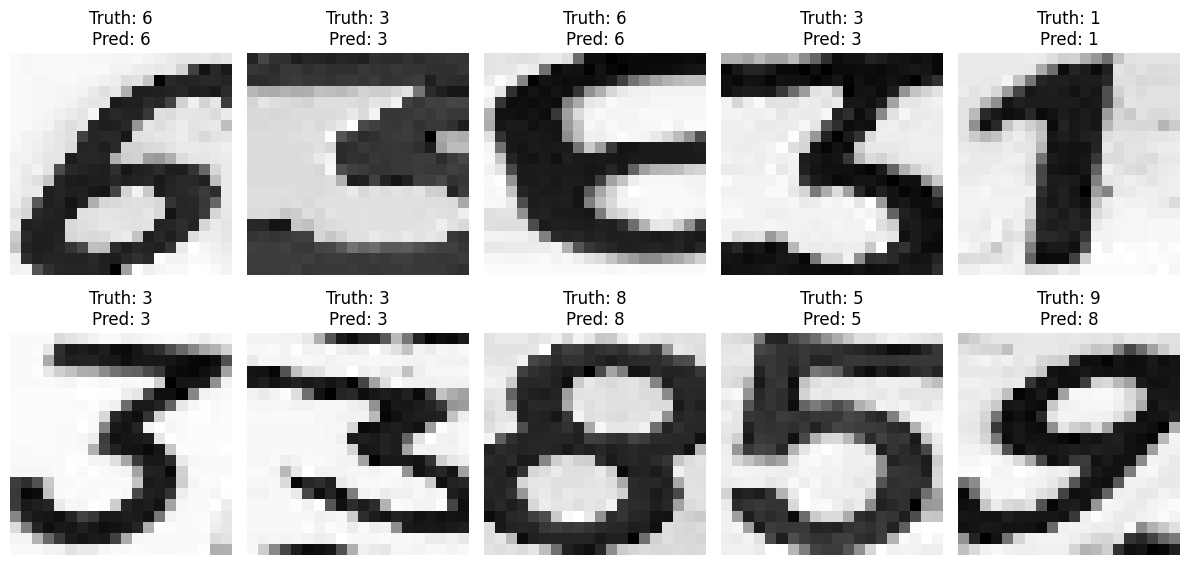

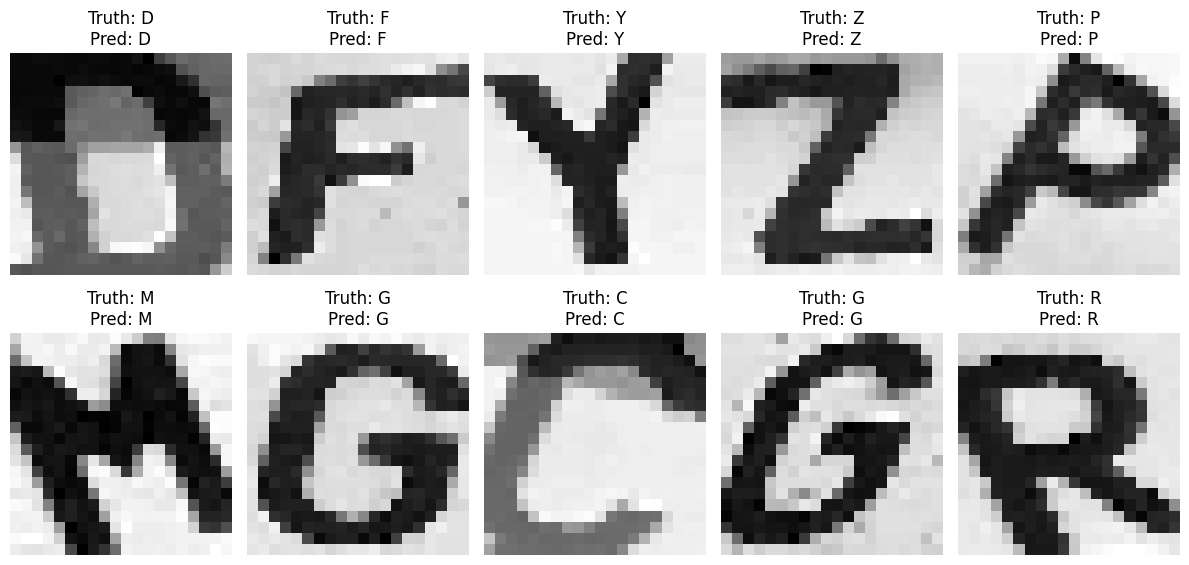

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def visualize_predictions(test_images, ground_truth_labels, predicted_labels, num_images_to_display=10):
    # Define number of images to display
    num_images_to_display = min(num_images_to_display, len(ground_truth_labels))

    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Select a subset of images and their corresponding labels and predictions
    indices = np.random.choice(range(len(ground_truth_labels)), size=num_images_to_display, replace=False)

    for i in range(num_images_to_display):
        plt.subplot(2, num_images_to_display // 2, i + 1)
        
        # Reshape to 20x20 for displaying the image
        img = test_images[indices[i]].reshape(20, 20)  # Reshape to original dimensions
        plt.imshow(img, cmap='gray')
        
        plt.title(f'Truth: {ground_truth_labels[indices[i]]}\nPred: {predicted_labels[indices[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for Numbers:
# Assuming you have:
# - `X_test_numbers`, `y_test_numbers` for numbers
# - `knn_numbers` trained model

# Get predictions for the test set of numbers
y_pred_numbers = knn_numbers.predict(X_test_numbers)

# Convert predictions and ground truth back to numbers
ground_truth_numbers = label_encoder_numbers.inverse_transform(y_test_numbers)
predicted_numbers = label_encoder_numbers.inverse_transform(y_pred_numbers)

# Visualize predictions for numbers
visualize_predictions(X_test_numbers, ground_truth_numbers, predicted_numbers, num_images_to_display=10)

# Example usage for Letters:
# Assuming you have:
# - `X_test_letters`, `y_test_letters` for letters
# - `knn_letters` trained model

# Get predictions for the test set of letters
y_pred_letters = knn_letters.predict(X_test_letters)

# Convert predictions and ground truth back to letters
ground_truth_letters = label_encoder_letters.inverse_transform(y_test_letters)
predicted_letters = label_encoder_letters.inverse_transform(y_pred_letters)

# Visualize predictions for letters
visualize_predictions(X_test_letters, ground_truth_letters, predicted_letters, num_images_to_display=10)
